In [1]:
# import libraries
import random
import matplotlib.pyplot as plt
import networkx as nx
import FrameworkLib as FL
import numpy as np
from tqdm import tqdm
import pickle

In [2]:
# Define the box margins
box_margin = 10


# maximum distance between agents
max_dist = 7

# min and max agents
min_agents = 4
max_agents = 32
step = 4

# num of graphs for each number of agents
num_graphs = 5000

graphs = []

# Generate graphs
for num_agents in tqdm(range(min_agents, max_agents + 1, step), desc='Generating graphs'):
    num_graph = 0
    while num_graph < num_graphs:
        
        # Assign random positions within a box (e.g., 10x10)
        pos = {i: (random.uniform(0, box_margin), random.uniform(0, box_margin)) for i in range(num_agents)}
        # pos = {i: (random.gauss(0.5*box_margin, box_margin), random.gauss(0.5*box_margin, box_margin)) for i in range(num_agents)}
        
        # Generate a random graph with num_agents nodes
        G = FL.generate_graph(pos,max_dist)
        
        # if the graph is connected, add it to the list
        # if FL.is_rigid(G):
        if nx.is_connected(G):
        # if True:
            graphs.append(G)
            num_graph += 1

Generating graphs: 100%|██████████| 8/8 [00:23<00:00,  2.95s/it]


In [3]:
# compute metrics for graphs
for G in tqdm(graphs, desc="Processing graphs"):
        
    # get the spreadiness
    dispersion = FL.get_dispersion(G)
    coverage = FL.get_coverage(G)
    
    # get the rigidity matrix
    rigid, EGVL = FL.is_rigid(G)
    EGVL_rig = np.real(EGVL)
    
    # get the edge connectivity
    edge_relation = FL.get_edge_relation(G)
    
    # get density
    density = FL.get_density(G)
    
    # Save values as graph attributes
    G.graph['dispersion'] = dispersion
    G.graph['coverage'] = coverage
    G.graph['EGVL_RIG'] = EGVL_rig
    G.graph['edge_relation'] = edge_relation
    G.graph['density'] = density
    

Processing graphs: 100%|██████████| 40000/40000 [02:28<00:00, 270.05it/s]


In [47]:
threshold = 10
# Filter graphs based on the number of nodes
filtered_graphs = {i: [] for i in range(1, int((max_agents - min_agents + step)/step) + 1)}
rigid_graphs = {i: [] for i in range(1, int((max_agents - min_agents + step)/step) + 1)}
for G in tqdm(graphs, desc="Processing graphs"):
    num_nodes = G.number_of_nodes()
    pos = int((num_nodes - min_agents) / step) + 1
    filtered_graphs[pos].append(G)
    if G.graph['EGVL_RIG'] > threshold:
        rigid_graphs[pos].append(G)

Processing graphs: 100%|██████████| 40000/40000 [00:00<00:00, 1203798.26it/s]


In [15]:
variables_to_save = {
    'min_agents': min_agents,
    'max_agents': max_agents,
    'step': step,
    'num_graphs': num_graphs,
    'box_margin': box_margin,
    'max_dist': max_dist,
    'filtered_graphs': filtered_graphs,
    'rigid_graphs': rigid_graphs,
    'threshold': threshold
}

name  = 'Nmin_' + str(min_agents) + '_Nmax' + str(max_agents) + '_Step' + str(step) + '_Ngraphs' + str(num_graphs) + '_Margin' + str(box_margin) + '_MaxD' + str(max_dist) + '_Ethr' + str(threshold) + '.pkl'
with open('../../fig/results/MonteCarlo/' + str(name), 'wb') as f:
    pickle.dump(variables_to_save, f)

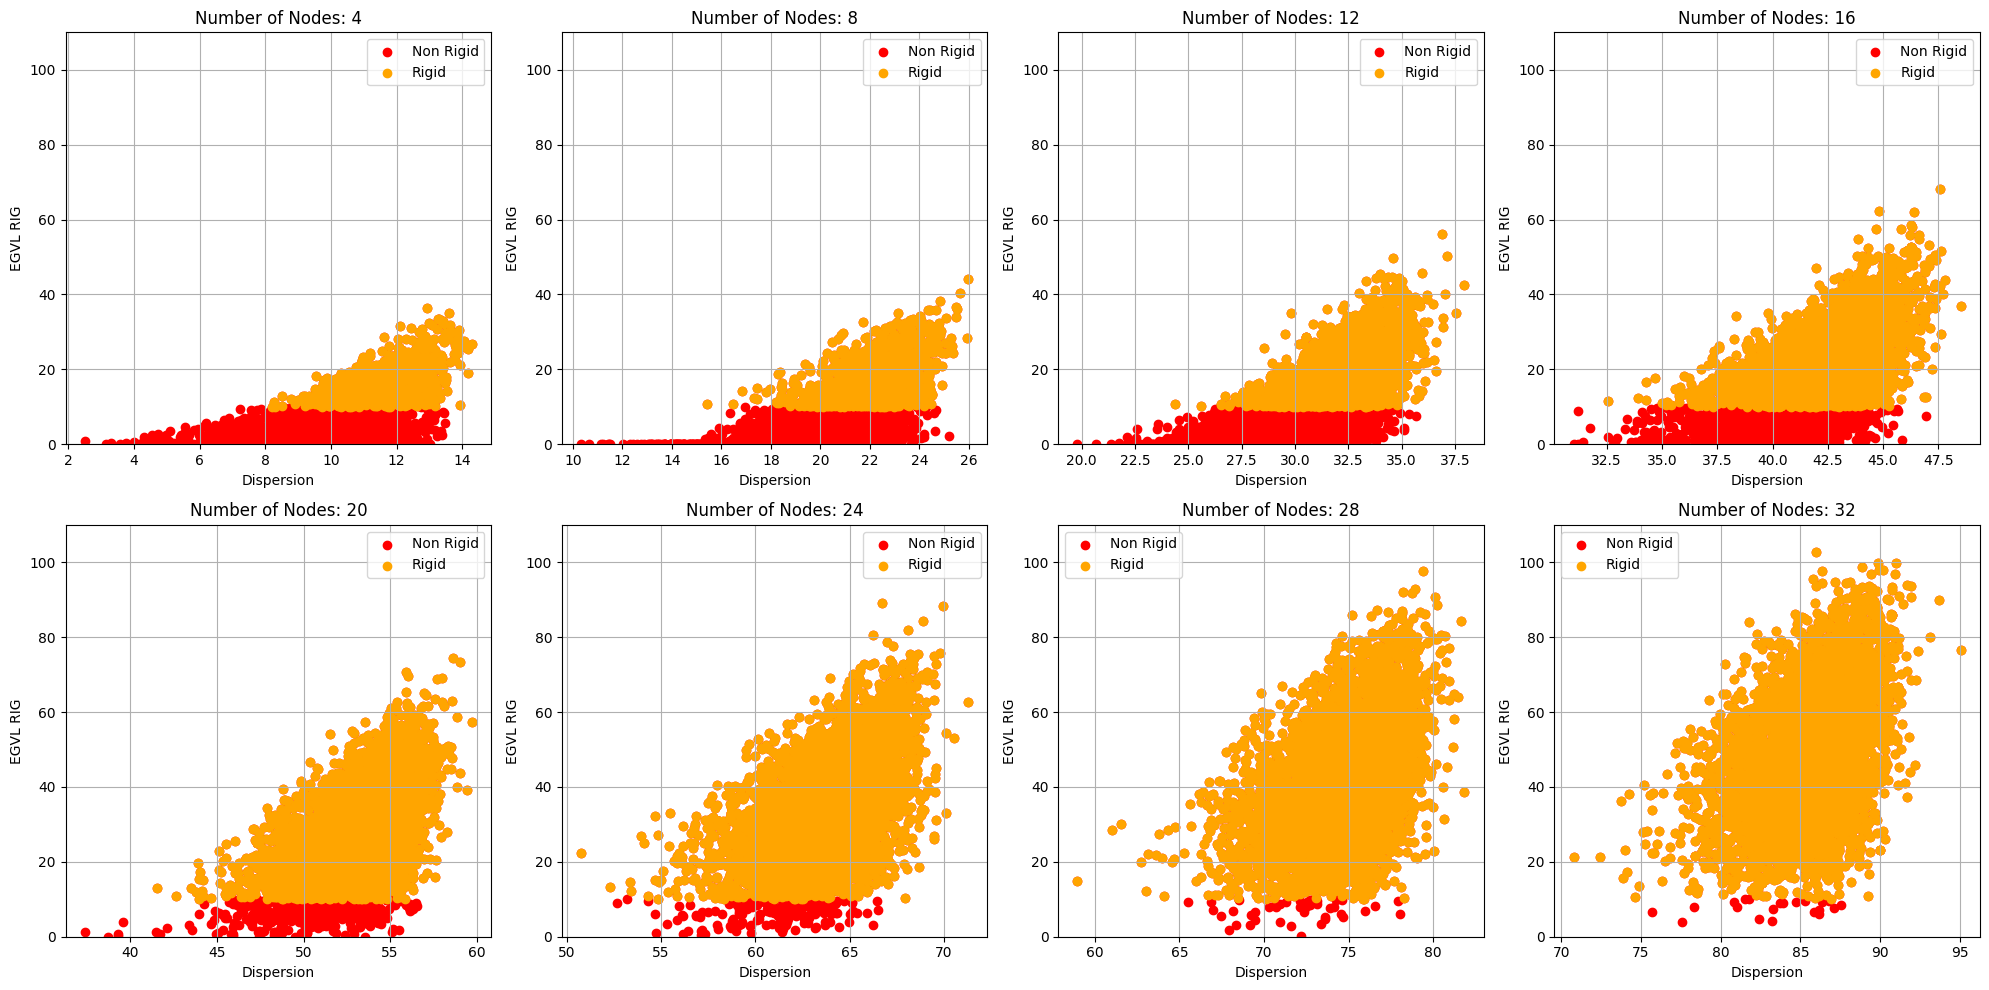

In [39]:
# fig organization
max_row_length = 4
num_rows = int(np.ceil((max_agents - min_agents) / (step * (max_row_length))))
fig, axes = plt.subplots(nrows=num_rows, ncols=max_row_length, figsize=(5 * max_row_length, 5 * num_rows))
axes = axes.flatten()

# Plot
pos = 0
idx = 0
for num_nodes in range(min_agents, max_agents + 1, step):
    pos += 1
    if len(filtered_graphs[pos]) > 0:
        
        ax = axes[idx]
        idx += 1
        
        coverage = [G.graph['coverage'] for G in filtered_graphs[pos] if len(G.nodes) == num_nodes]
        dispersion = [G.graph['dispersion'] for G in filtered_graphs[pos] if len(G.nodes) == num_nodes]
        EGVL_RIG = [G.graph['EGVL_RIG'] for G in filtered_graphs[pos] if len(G.nodes) == num_nodes]
        
        # do the same for the non rigid graphs
        coverage_rigid = [G.graph['coverage'] for G in rigid_graphs[pos] if len(G.nodes) == num_nodes]
        dispersion_rigid = [G.graph['dispersion'] for G in rigid_graphs[pos] if len(G.nodes) == num_nodes]
        EGVL_RIG_rigid = [G.graph['EGVL_RIG'] for G in rigid_graphs[pos] if len(G.nodes) == num_nodes]
        
        # dispersion
        ax.scatter(dispersion, EGVL_RIG, label='Non Rigid', color='red')
        ax.scatter(dispersion_rigid, EGVL_RIG_rigid, label='Rigid', color='orange')
        ax.set_title(f'Number of Nodes: {num_nodes}')
        ax.set_xlabel('Dispersion')
        ax.set_ylabel('EGVL RIG')
        
        # coverage
        # ax.scatter(coverage, EGVL_RIG, label='Non Rigid', color='lightgreen')
        # ax.scatter(coverage_rigid, EGVL_RIG_rigid, label='Rigid', color='green')
        # ax.set_title(f'Number of Nodes: {num_nodes}')
        # ax.set_xlabel('Coverage')
        # ax.set_ylabel('EGVL RIG')
        
        ax.legend()
        ax.set_ylim(0, 110)
        # ax.set_xlim(0, 100)
        ax.grid()



# Hide any unused subplots
for idx in range(len(range(min_agents, max_agents + 1)), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


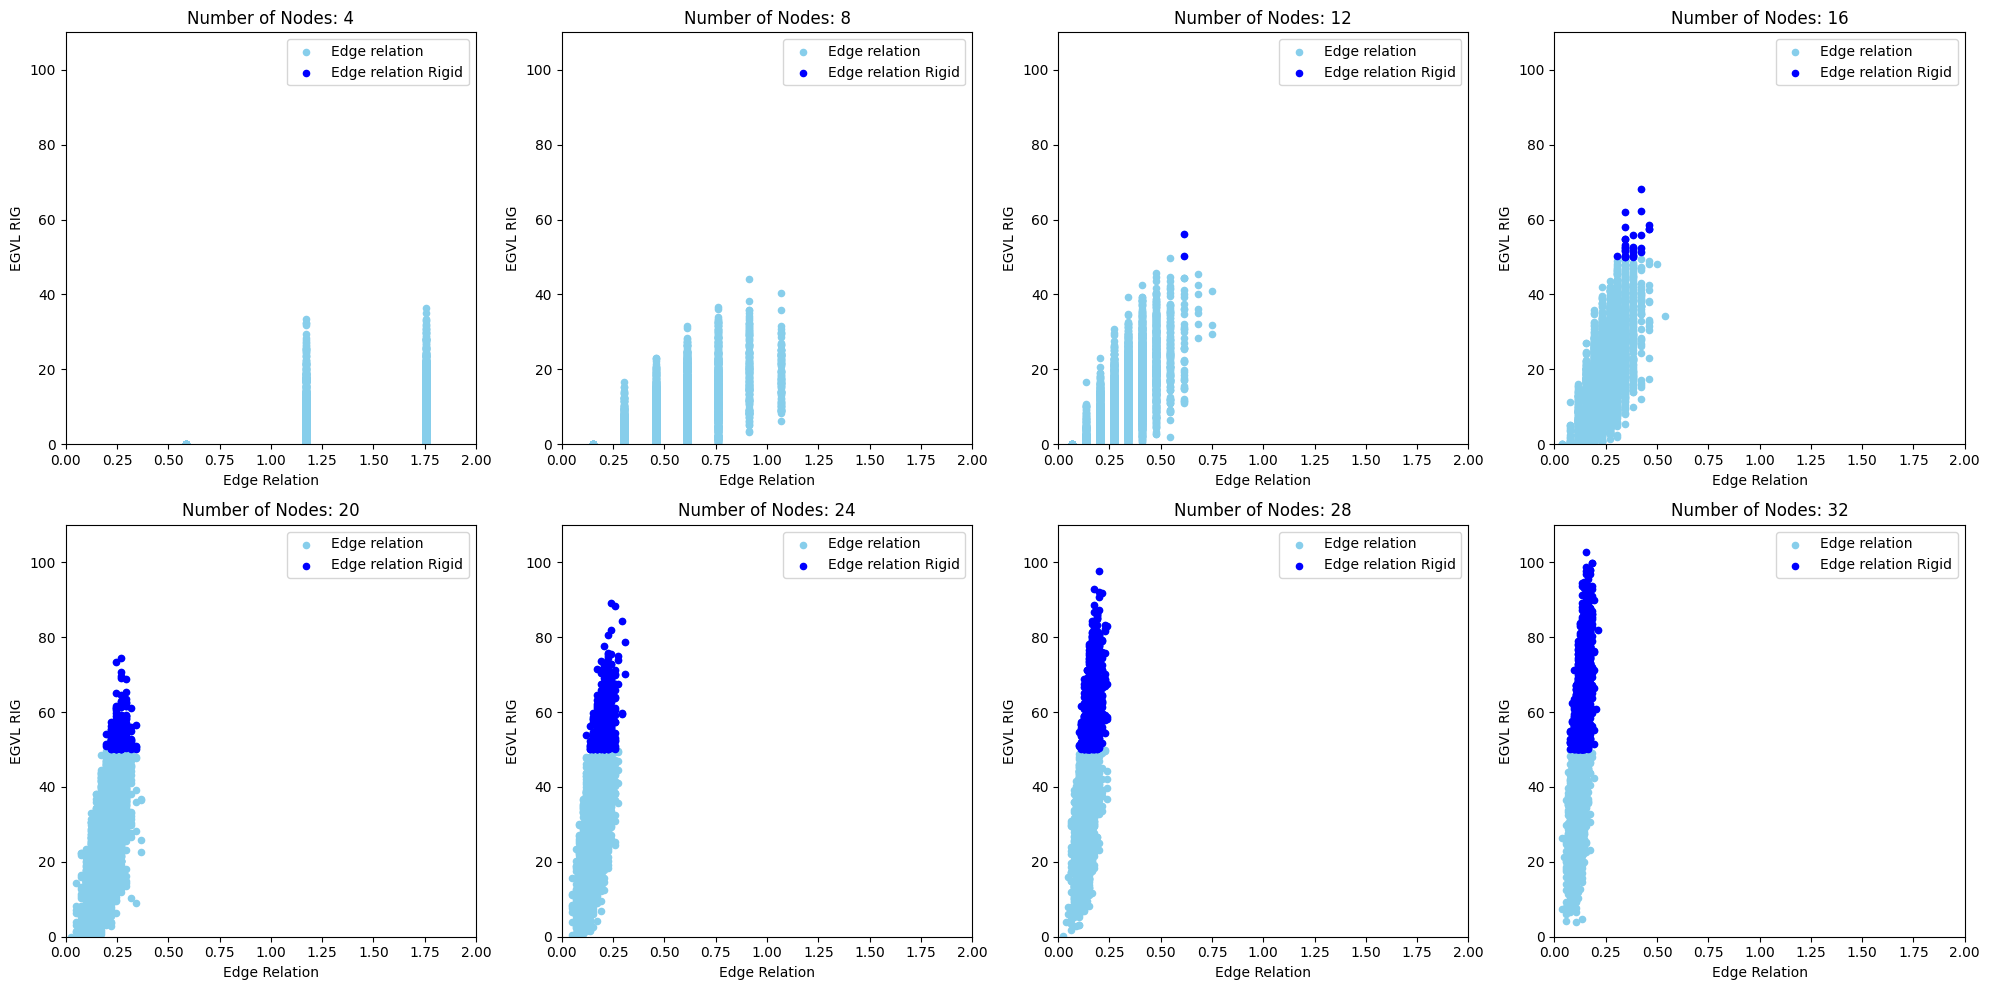

In [42]:
fig, axes = plt.subplots(nrows=num_rows, ncols=max_row_length, figsize=(5 * max_row_length, 5 * num_rows))
axes = axes.flatten()

pos = 0
idx = 0
for num_nodes in range(min_agents, max_agents + 1, step):
    
    pos = int((num_nodes - min_agents) / step) + 1
    
    ax = axes[idx]
    idx += 1
    
    edge_relation = [G.graph['edge_relation'] for G in filtered_graphs[pos]]
    EGVL_RIG = [G.graph['EGVL_RIG'] for G in filtered_graphs[pos]]
    ax.scatter(edge_relation, EGVL_RIG, label='Edge relation', s=20, color='skyblue')
    
    # same thing with rigid graphs
    edge_relation_rigid = [G.graph['edge_relation'] for G in rigid_graphs[pos] if len(G.nodes) == num_nodes]
    EGVL_RIG_rigid = [G.graph['EGVL_RIG'] for G in rigid_graphs[pos] if len(G.nodes) == num_nodes]
    ax.scatter(edge_relation_rigid, EGVL_RIG_rigid, label='Edge relation Rigid', s=20, color='blue')
    
    ax.set_title(f'Number of Nodes: {num_nodes}')
    ax.set_xlabel('Edge Relation')
    ax.set_ylabel('EGVL RIG')
    ax.set_ylim(0, 110)
    ax.set_xlim(0, 2)
    ax.legend()

# Hide any unused subplots
for idx in range(len(range(min_agents, max_agents + 1)), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

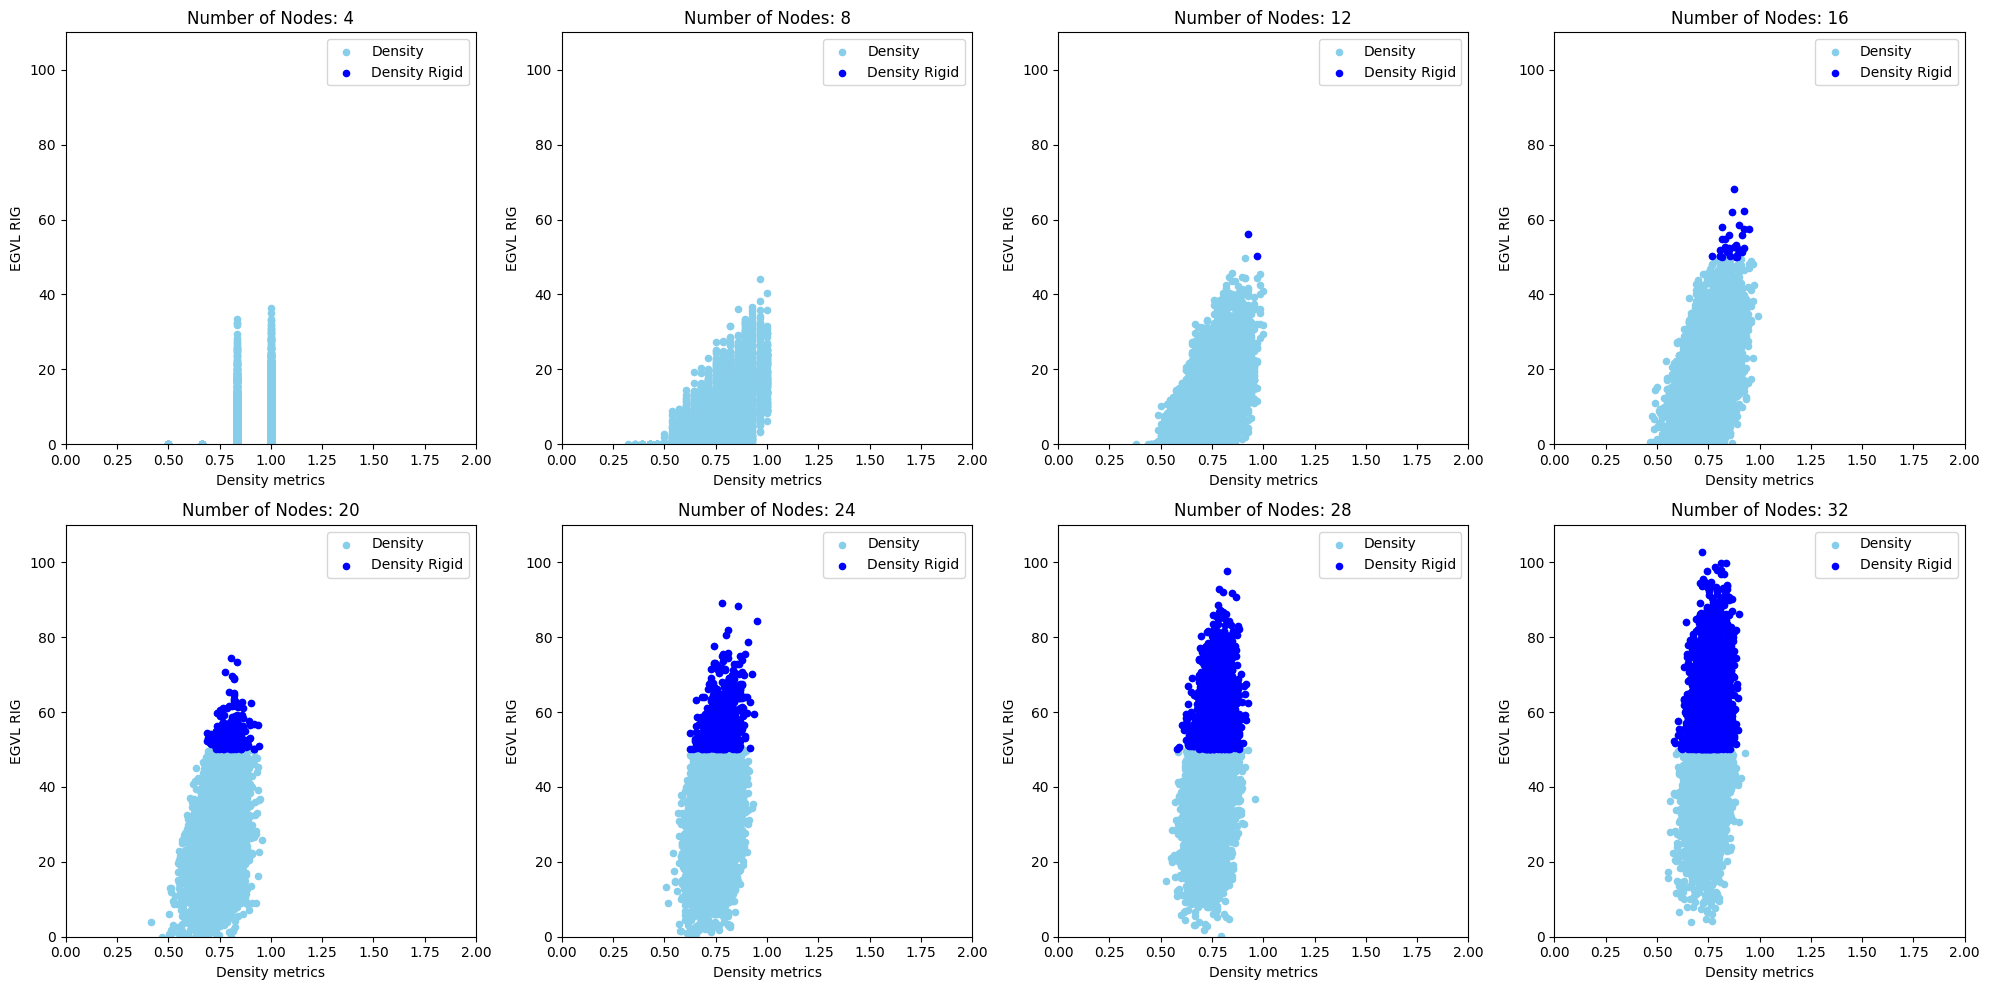

In [46]:
fig, axes = plt.subplots(nrows=num_rows, ncols=max_row_length, figsize=(5 * max_row_length, 5 * num_rows))
axes = axes.flatten()

pos = 0
idx = 0
for num_nodes in range(min_agents, max_agents + 1, step):
    
    pos = int((num_nodes - min_agents) / step) + 1
    
    ax = axes[idx]
    idx += 1
    
    density = [G.graph['density'] for G in filtered_graphs[pos]]
    EGVL_RIG = [G.graph['EGVL_RIG'] for G in filtered_graphs[pos]]
    ax.scatter(density, EGVL_RIG, color='skyblue', label='Density', s=20)
    
    # same thing with rigid graphs
    density_rigid = [G.graph['density'] for G in rigid_graphs[pos] if len(G.nodes) == num_nodes]
    EGVL_RIG_rigid = [G.graph['EGVL_RIG'] for G in rigid_graphs[pos] if len(G.nodes) == num_nodes]
    ax.scatter(density_rigid, EGVL_RIG_rigid, color='blue', label='Density Rigid', s=20)
    
    ax.set_title(f'Number of Nodes: {num_nodes}')
    ax.set_xlabel('Density metrics')
    ax.set_ylabel('EGVL RIG')
    ax.set_ylim(0, 110)
    ax.set_xlim(0, 2)
    ax.legend()

# Hide any unused subplots
for idx in range(len(range(min_agents, max_agents + 1)), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

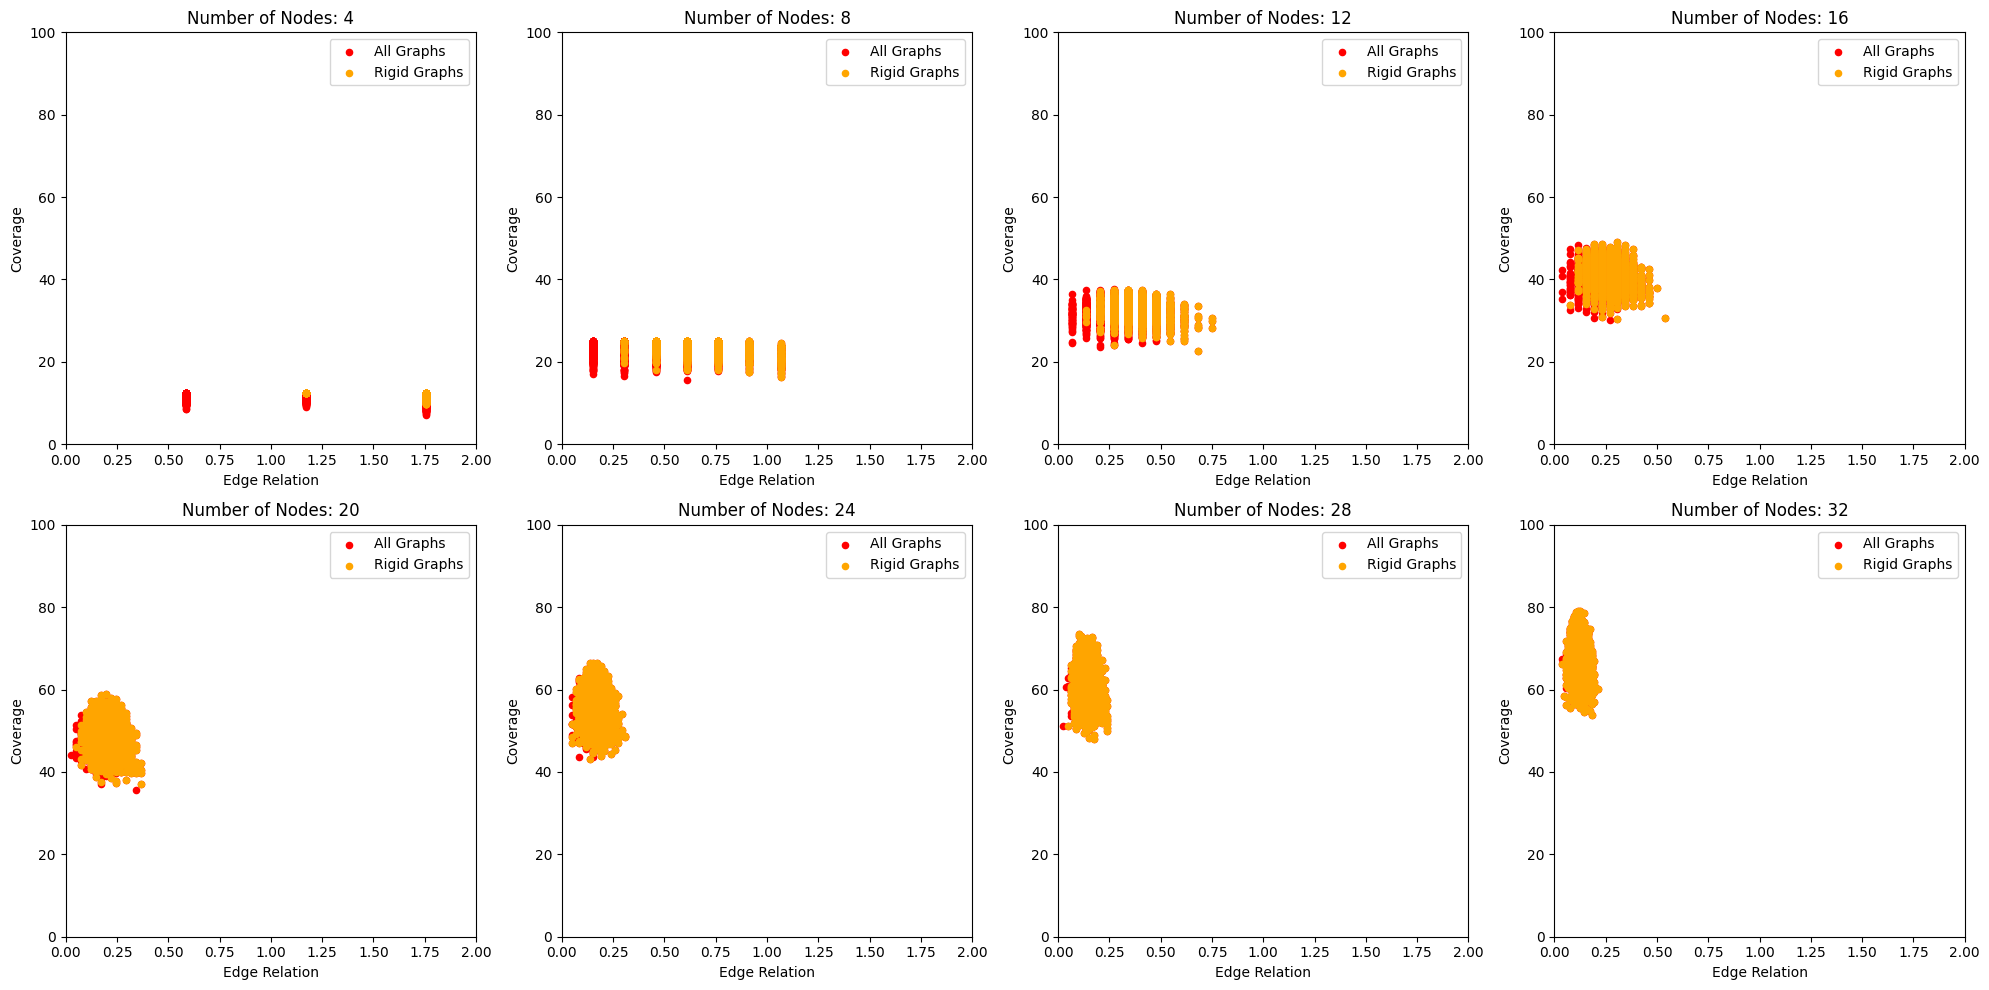

In [49]:
fig, axes = plt.subplots(nrows=num_rows, ncols=max_row_length, figsize=(5 * max_row_length, 5 * num_rows))
axes = axes.flatten()

pos = 0
idx = 0
for num_nodes in range(min_agents, max_agents + 1, step):
    
    pos = int((num_nodes - min_agents) / step) + 1
    
    ax = axes[idx]
    idx += 1
    
    coverage = [G.graph['coverage'] for G in filtered_graphs[pos]]
    edge_relation = [G.graph['edge_relation'] for G in filtered_graphs[pos]]
    EGVL_RIG = [G.graph['EGVL_RIG'] for G in filtered_graphs[pos]]
    
    # Scatter plot for all graphs
    ax.scatter(edge_relation, coverage, color='red', label='All Graphs', s=20)
    
    # same thing with rigid graphs
    edge_relation_rigid = [G.graph['edge_relation'] for G in rigid_graphs[pos] if len(G.nodes) == num_nodes]
    coverage_rigid = [G.graph['coverage'] for G in rigid_graphs[pos] if len(G.nodes) == num_nodes]
    
    # Scatter plot for rigid graphs
    ax.scatter(edge_relation_rigid, coverage_rigid, color='orange', label='Rigid Graphs', s=20)
    
    ax.set_title(f'Number of Nodes: {num_nodes}')
    ax.set_xlabel('Edge Relation')
    ax.set_ylabel('Coverage')
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 2)
    ax.legend()

# Hide any unused subplots
for idx in range(len(range(min_agents, max_agents + 1)), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

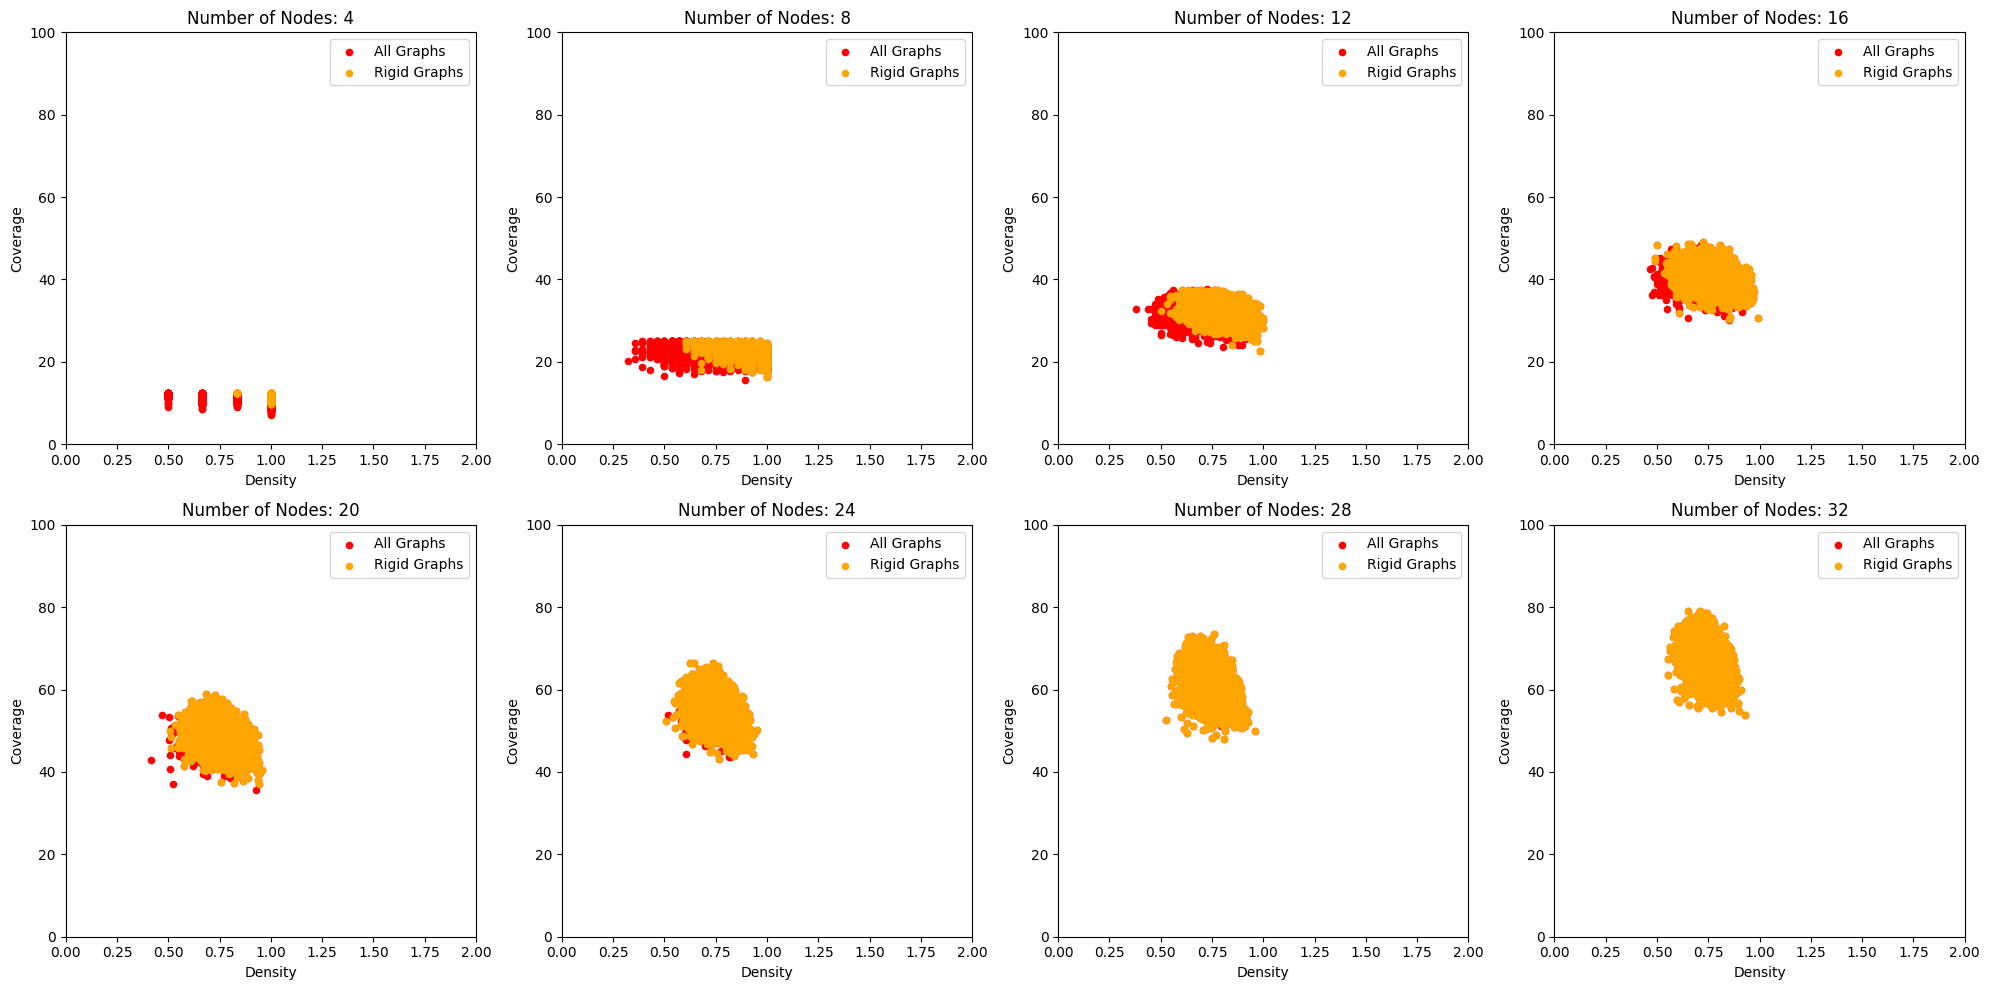

In [50]:
fig, axes = plt.subplots(nrows=num_rows, ncols=max_row_length, figsize=(5 * max_row_length, 5 * num_rows))
axes = axes.flatten()

pos = 0
idx = 0
for num_nodes in range(min_agents, max_agents + 1, step):
    
    pos = int((num_nodes - min_agents) / step) + 1
    
    ax = axes[idx]
    idx += 1
    
    density = [G.graph['density'] for G in filtered_graphs[pos]]
    coverage = [G.graph['coverage'] for G in filtered_graphs[pos]]    
    
    # Scatter plot for all graphs
    ax.scatter(density, coverage, color='red', label='All Graphs', s=20)
    
    # same thing with rigid graphs
    density_rigid = [G.graph['density'] for G in rigid_graphs[pos] if len(G.nodes) == num_nodes]
    coverage_rigid = [G.graph['coverage'] for G in rigid_graphs[pos] if len(G.nodes) == num_nodes]
           
    # Scatter plot for rigid graphs
    ax.scatter(density_rigid, coverage_rigid, color='orange', label='Rigid Graphs', s=20)
    
    ax.set_title(f'Number of Nodes: {num_nodes}')
    ax.set_xlabel('Density')
    ax.set_ylabel('Coverage')
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 2)
    ax.legend()

# Hide any unused subplots
for idx in range(len(range(min_agents, max_agents + 1)), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()